In [35]:
# image classifier part
import tensorflow as tf
#from tensorflow.keras import layers
#from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, LSTM,Dropout,Conv2D,TimeDistributed
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, TimeDistributed, Dropout
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import (Conv2D, TimeDistributed, MaxPooling2D,
                                     MaxPooling3D, AveragePooling2D, Conv2DTranspose, UpSampling2D,
                                     BatchNormalization,
                                     Dense, Flatten, Reshape,Dropout)

In [36]:
#main_classifier
@tf.function
def real_cal(r, phi):
    return r * tf.math.cos(phi)

@tf.function
def imag_cal(r, phi):
    return r * tf.math.sin(phi)

@tf.function
def oscillator_loop(X_r, X_i, omegas, num_steps):
    # batch_size x timesteps X dim
    r_arr = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True) # creates empty array to save r_t
    phi_arr = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    r_t = tf.ones((tf.shape(X_r)[0], tf.shape(X_r)[-1])) # Initializing r_t
    phis = tf.zeros((tf.shape(X_r)[0], tf.shape(X_r)[-1])) # Initislizing phi_t
    dt = 1/128
    input_scaler = 2
    beta=1

    for t in tf.range(num_steps):
        input_r = input_scaler*X_r[:,t,:]*tf.math.cos(phis)
        input_phi = input_scaler*X_i[:,t,:]*tf.math.sin(phis)
        r_t = r_t + ((1 - beta*tf.square(r_t)) * r_t + input_r) * dt
        phis = phis + (omegas - input_phi) * dt
        r_arr = r_arr.write(r_arr.size(), r_t)  #1000,1,2
        phi_arr = phi_arr.write(phi_arr.size(), phis)
    r_arr = tf.transpose(r_arr.stack(), [1, 0, 2])  # Changing dimensions to 1,1000,2
    phi_arr = tf.transpose(phi_arr.stack(), [1, 0, 2])
    return r_arr, phi_arr

class Hopf(tf.keras.layers.Layer):

    def __init__(self, units, num_steps, min_omega=0.1,
                 max_omega=64.1,train_omegas=True, **kwargs):
        super(Hopf, self).__init__(**kwargs)
        self.units = units
        self.num_steps = num_steps
        self.train_omegas=train_omegas
        self.max_omega=max_omega
        self.min_omega=min_omega
        # self.omegas = tf.linspace(min_omega, max_omega, self.units) * (2*3.1415)
        # self.omegas = tf.cast(tf.expand_dims(self.omegas, 0), 'float32')

        omega_init=tf.random.uniform((1,self.units),-1,1)
        self.omegas=tf.Variable(omega_init,trainable=self.train_omegas)

    def call(self, X_r, X_i):
        omega_intl = self.max_omega - self.min_omega
        omega_inp = tf.sigmoid(0.5*self.omegas) * omega_intl + self.min_omega


        r, phi = oscillator_loop(X_r, X_i, omega_inp , self.num_steps)
        z_real = real_cal(r, phi)
        z_imag = imag_cal(r, phi)
        return z_real, z_imag


duration = 32


In [37]:
class Model_classifier2(tf.keras.Model):
    def __init__(self, units1, units2,units21,units22,units23, units3,units4,  units5, units7, units6,  **kwargs):
        super(Model_classifier2, self).__init__(**kwargs)

        self.d1=tf.keras.layers.Dense(units1, activation='relu')  # 250
        self.d2=tf.keras.layers.Dense(units2, activation='relu')  #200
        self.d21=tf.keras.layers.Dense(units21, activation='relu')  #150
        self.d22=tf.keras.layers.Dense(units22, activation='relu')  #100
        self.d23=tf.keras.layers.Dense(units23, activation='relu')  #50


        self.d3_r=tf.keras.layers.Dense(units3, activation='relu')
        self.d3_i=tf.keras.layers.Dense(units3, activation='relu')
        self.osc1=Hopf(units4, num_steps=duration, min_omega=0.1, max_omega=64.1, train_omegas=True)

        #self.d3_r1=tf.keras.layers.Dense(units9, activation='relu')
        #self.d3_i1=tf.keras.layers.Dense(units9, activation='relu')
        #self.osc2=Hopf(units10, num_steps=duration, min_omega=0.1, max_omega=64.1, train_omegas=True)

        self.d4_r=tf.keras.layers.Dense(units5, activation='tanh')
        self.d4_i=tf.keras.layers.Dense(units5, activation='tanh')

        self.d5=tf.keras.layers.Dense(units7, activation='tanh')
        #self.d6=tf.keras.layers.Dense(units8, activation='tanh')

        #self.d5_i=tf.keras.layers.Dense(units7, activation='tanh')
        self.out_dense=tf.keras.layers.Dense(units6, activation='linear')
    
    def call(self, X):
        out1=tf.keras.layers.TimeDistributed(self.d1)(X)    #250
        out2=tf.keras.layers.TimeDistributed(self.d2)(out1) #200
        out21=tf.keras.layers.TimeDistributed(self.d21)(out2) #150
        out22=tf.keras.layers.TimeDistributed(self.d22)(out21) #100
        out23=tf.keras.layers.TimeDistributed(self.d23)(out22) #50


        out3_r=tf.keras.layers.TimeDistributed(self.d3_r)(out23) #25
        out3_i=tf.keras.layers.TimeDistributed(self.d3_i)(out23)
        z1_r, z1_i = self.osc1(out3_r, out3_i)

        #out3_r1=tf.keras.layers.TimeDistributed(self.d3_r1)(z1_r)
        #out3_i1=tf.keras.layers.TimeDistributed(self.d3_i1)(z1_i)
        #z1_r1, z1_i1 = self.osc2(out3_r1, out3_i1)

        out4_r=tf.keras.layers.TimeDistributed(self.d4_r)(z1_r)
        out4_i=tf.keras.layers.TimeDistributed(self.d4_i)(z1_i)
        concat_inp=tf.concat([out4_r,out4_i],2)
        out5=tf.keras.layers.TimeDistributed(self.d5)(concat_inp)
        #out6=tf.keras.layers.TimeDistributed(self.d6)(out5)


        out_final=tf.keras.layers.TimeDistributed(self.out_dense)(out5)

        return [out_final]
        #return [out3_r,out3_i]

model_classifier2 =  Model_classifier2(250, 200,150,100, 50,25, 25,20, 15,10)

In [38]:
import numpy as np
import cv2

X_train_img=np.load('D:/lab_work_25/march/hybrid/Data_train/training_data/X_trn_img.npy')
print(X_train_img.shape)

X_train_img = X_train_img.reshape(40000, 32, 400)
X_train_img = X_train_img.astype('float32')/255.0
X_train_img.shape


(40000, 32, 20, 20)


(40000, 32, 400)

In [39]:
print(X_train_img.shape)


(40000, 32, 400)


In [40]:
X_test_img=np.load('D:/lab_work_25/march/hybrid/Data_train/testing_data/x_test_img.npy')
print(X_test_img.shape)


X_test_img = X_test_img.reshape(2000, 32, 400)

X_test_img = X_test_img.astype('float32')/255.0
X_test_img.shape

(2000, 32, 20, 20)


(2000, 32, 400)

In [41]:
print(X_train_img[0,1,:])

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.11764706 0.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         0.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.
 0.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         

In [42]:
y_train=np.load('D:/Lab_work_24/dec/cGAN/OGAN_TRAINED/Dataset/Y_train_labels.npy')
print(y_train.shape)

(40000,)


In [43]:
print(y_train[3990:4005,])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


In [44]:
def ramp_classifier_output(labels,n=10):
    ramp_out=np.zeros((labels.shape[0],32,n))
    ramp=np.linspace(0,2,32)

    for i in range(labels.shape[0]):
        ramp_out[i,:,int(labels[i])]=ramp
    return ramp_out

In [45]:
y_train_classify=ramp_classifier_output(y_train,n=10)
print(y_train_classify.shape)

(40000, 32, 10)


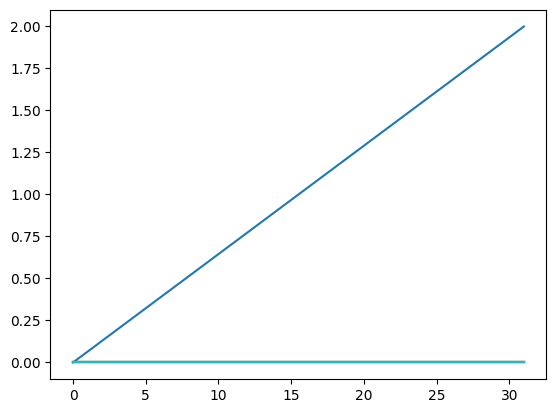

In [46]:
plt.plot(y_train_classify[0,:,:])

In [47]:
from sklearn.model_selection import train_test_split


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_train_img, y_train_classify, test_size=0.1, random_state=42, shuffle=True)

In [49]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36000, 32, 400), (36000, 32, 10), (4000, 32, 400), (4000, 32, 10))

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model_classifier2.compile(optimizer, 'mse', metrics=['accuracy'])

In [51]:
history_linear = model_classifier2.fit(X_train, y_train*8, epochs=500, batch_size=100, validation_data=(X_test, y_test * 8))

Epoch 1/500
360/360 [==============================] - 21s 38ms/step - loss: 8.1447 - accuracy: 0.1401 - val_loss: 7.5727 - val_accuracy: 0.2410
Epoch 2/500
360/360 [==============================] - 15s 41ms/step - loss: 7.2027 - accuracy: 0.3718 - val_loss: 6.8411 - val_accuracy: 0.4937
Epoch 3/500
360/360 [==============================] - 14s 40ms/step - loss: 6.5435 - accuracy: 0.5574 - val_loss: 6.2187 - val_accuracy: 0.6150
Epoch 4/500
360/360 [==============================] - 15s 41ms/step - loss: 5.9674 - accuracy: 0.6295 - val_loss: 5.6953 - val_accuracy: 0.6599
Epoch 5/500
360/360 [==============================] - 15s 41ms/step - loss: 5.4835 - accuracy: 0.6830 - val_loss: 5.2553 - val_accuracy: 0.7101
Epoch 6/500
360/360 [==============================] - 15s 40ms/step - loss: 5.0699 - accuracy: 0.7206 - val_loss: 4.8498 - val_accuracy: 0.7351
Epoch 7/500
360/360 [==============================] - 15s 42ms/step - loss: 4.6966 - accuracy: 0.7481 - val_loss: 4.5195 - val_ac

In [52]:
'''history_linear = model_classifier2.fit(X_train, y_train*8, epochs=300, batch_size=100, validation_data=(X_test, y_test * 8))'''

'history_linear = model_classifier2.fit(X_train, y_train*8, epochs=300, batch_size=100, validation_data=(X_test, y_test * 8))'

In [53]:
'''history_linear = model_classifier2.fit(X_train, y_train*8, epochs=300, batch_size=100, validation_data=(X_test, y_test * 8))'''

'history_linear = model_classifier2.fit(X_train, y_train*8, epochs=300, batch_size=100, validation_data=(X_test, y_test * 8))'

In [64]:
model_classifier2.save_weights('D:/lab_work_25/march/hybrid/save_weights/oscillator_classifier_high_net3.h5')

In [65]:
trained_omegas1=model_classifier2.osc1.omegas.numpy()
np.save('D:/lab_work_25/march/hybrid/save_weights/trained_omegas_classifier_high_net3.npy',trained_omegas1)

In [56]:
x_test1=np.load('D:/lab_work_25/march/hybrid/Data_train/testing_data/x_test_img1.npy')
print(x_test1.shape)
y_test1=np.load('D:/lab_work_25/march/hybrid/Data_train/testing_data/Y_test_labels.npy')
print(y_test1.shape)

(1000, 32, 20, 20)
(1000, 32, 10)


In [57]:
x_test1 = x_test1.reshape(1000, 32, 400)
x_test1 = x_test1.astype('float32')/255.0
x_test1.shape

(1000, 32, 400)

In [58]:
out=model_classifier2.predict(x_test1,batch_size=1)

1000/1000 [==============================] - 4s 4ms/step


In [59]:
out = np.array(out)
print(out.shape)

(1, 1000, 32, 10)


In [60]:
out=np.squeeze(out,axis=0)
print(out.shape)

(1000, 32, 10)


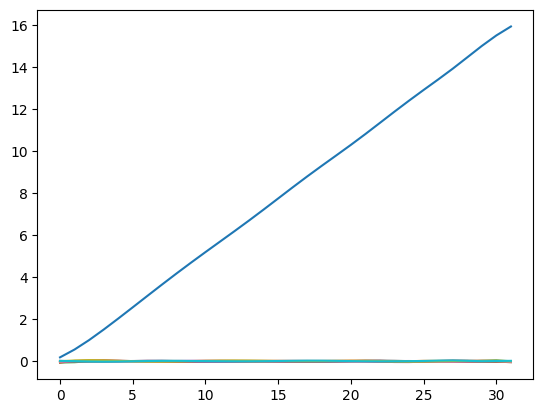

In [61]:
plt.plot(out[0,:,:])

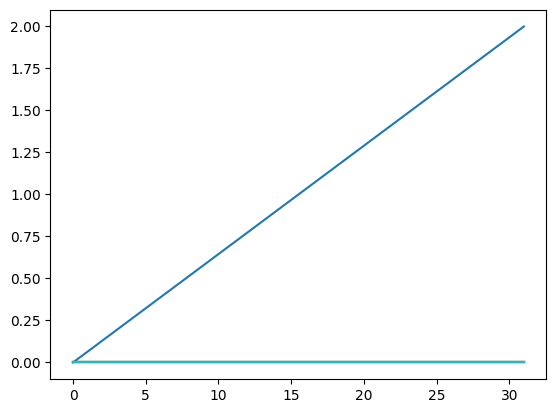

In [62]:
plt.plot(y_test1[0,:,:])

In [63]:
import numpy as np

def calculate_accuracy(out_test, all_samples_test_array):
    # Initialize the counter
    c_test = 0
    # Number of samples
    num_samples = out_test.shape[0]

    # Iterate over each sample
    for ii in range(num_samples):
        # Find the index of the maximum value in the current row of out_test
        a_test=sum(out_test[ii,:])
        indices_test = np.argmax(a_test)

        # Find the index of the maximum value in the current row of all_samples_test_array
        b_test=sum(all_samples_test_array[ii,:])
        indices1_test = np.argmax(b_test)

        # Check if the indices match
        if indices_test == indices1_test:
            c_test += 1

    # Calculate the accuracy
    accuracy = c_test / num_samples
    return accuracy

# Example usage
out_test1 = out  # Example data, replace with actual data
all_samples_test_array1 = y_test1 # Example data, replace with actual data

accuracy = calculate_accuracy(out_test1, all_samples_test_array1)
print(f"Accuracy: {accuracy}")


Accuracy: 0.909
